# Stock Price Prediction
inspired/base by https://www.youtube.com/watch?v=QIUxPv5PJOY&list=WL&index=7&t=225s <br>
I decided to predict MS opening stock values not only based on their own data, but also Apple and HP data, to see, if "trends" in the branche improve the accuracy/MSE or if the not directly connected date worsens the result.

# Imports

In [1]:
import math
import pandas as pd
import numpy as np

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

#plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

print("Import successful")

#if you dont like the warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Import successful


# Processing data
Loading stock data from yahoo.

In [2]:
dfMS=web.DataReader("MS", data_source="yahoo", start="2010-01-01", end = "2020-08-01")
dfMS

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,31.969999,30.629999,30.700001,30.910000,20371000.0,25.759523
2010-01-05,32.130001,30.930000,31.010000,32.040001,22523400.0,26.701244
2010-01-06,32.590000,31.790001,31.969999,32.450001,17028500.0,27.042919
2010-01-07,33.270000,32.270000,32.459999,32.919998,18693000.0,27.434603
2010-01-08,32.820000,31.980000,32.599998,32.250000,15993400.0,26.876251
...,...,...,...,...,...,...
2020-07-27,51.570000,49.730000,49.910000,51.320000,12087100.0,50.964951
2020-07-28,51.220001,50.209999,50.830002,50.259998,7287900.0,49.912281
2020-07-29,50.660000,49.880001,50.270000,50.590000,8074300.0,50.240002


In [3]:
dfMS.rename(columns={"High":"MsHigh", "Low": "MsLow", "Open": "MsOpen", "Close": "MsClose",
                   "Volume": "MsVolume", "Adj Close":"MsAdj Close"}, inplace=True)
dfMS

,MsHigh,MsLow,MsOpen,MsClose,MsVolume,MsAdj Close
Date,,,,,,
2010-01-04,31.969999,30.629999,30.700001,30.910000,20371000.0,25.759523
2010-01-05,32.130001,30.930000,31.010000,32.040001,22523400.0,26.701244
2010-01-06,32.590000,31.790001,31.969999,32.450001,17028500.0,27.042919
2010-01-07,33.270000,32.270000,32.459999,32.919998,18693000.0,27.434603
2010-01-08,32.820000,31.980000,32.599998,32.250000,15993400.0,26.876251
...,...,...,...,...,...,...
2020-07-27,51.570000,49.730000,49.910000,51.320000,12087100.0,50.964951
2020-07-28,51.220001,50.209999,50.830002,50.259998,7287900.0,49.912281
2020-07-29,50.660000,49.880001,50.270000,50.590000,8074300.0,50.240002


In [4]:
dfA=web.DataReader("AAPL", data_source="yahoo", start="2010-01-01", end = "2020-08-01")
dfA.rename(columns={"High":"AHigh", "Low": "ALow", "Open": "AOpen", "Close": "AClose",
                   "Volume": "AVolume", "Adj Close":"AAdj Close"}, inplace=True)
dfA

,AHigh,ALow,AOpen,AClose,AVolume,AAdj Close
Date,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.419203
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.464878
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.043921
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,25.995777
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.168606
...,...,...,...,...,...,...
2020-07-27,379.619995,373.920013,374.839996,379.239990,30303500.0,378.557434
2020-07-28,378.200012,372.989990,377.470001,373.010010,25906400.0,372.338684
2020-07-29,380.920013,374.850006,375.000000,380.160004,22582300.0,379.475800


In [5]:
dfHP=web.DataReader("HP", data_source="yahoo", start="2010-01-01", end = "2020-08-01")
dfHP.rename(columns={"High":"HPHigh", "Low": "HPLow", "Open": "HPOpen", "Close": "HPClose",
                   "Volume": "HPVolume", "Adj Close":"HPAdj Close"}, inplace=True)
dfHP

,HPHigh,HPLow,HPOpen,HPClose,HPVolume,HPAdj Close
Date,,,,,,
2010-01-04,42.020000,40.709999,40.709999,41.980000,920000.0,28.247267
2010-01-05,44.459999,41.869999,41.990002,44.430000,3039400.0,29.895809
2010-01-06,46.090000,44.150002,44.480000,46.049999,2481200.0,30.985868
2010-01-07,46.490002,45.119999,45.880001,46.340000,1674100.0,31.180996
2010-01-08,48.580002,46.680000,46.900002,48.000000,2795600.0,32.297970
...,...,...,...,...,...,...
2020-07-27,20.590000,19.950001,20.040001,20.480000,1225200.0,20.203243
2020-07-28,20.639999,19.240000,20.379999,19.430000,1363200.0,19.167433
2020-07-29,19.889999,18.100000,19.490000,18.459999,3346400.0,18.210539


In [6]:
dfMS = dfMS[["MsHigh", "MsLow", "MsClose", "MsVolume", "MsAdj Close", "MsOpen"]] #reordering to make things easier
dfA = dfA[["AHigh", "ALow", "AClose", "AVolume", "AAdj Close", "AOpen"]]
dfHP = dfHP[["HPHigh", "HPLow", "HPClose", "HPVolume", "HPAdj Close", "HPOpen"]]
dfMS

,MsHigh,MsLow,MsClose,MsVolume,MsAdj Close,MsOpen
Date,,,,,,
2010-01-04,31.969999,30.629999,30.910000,20371000.0,25.759523,30.700001
2010-01-05,32.130001,30.930000,32.040001,22523400.0,26.701244,31.010000
2010-01-06,32.590000,31.790001,32.450001,17028500.0,27.042919,31.969999
2010-01-07,33.270000,32.270000,32.919998,18693000.0,27.434603,32.459999
2010-01-08,32.820000,31.980000,32.250000,15993400.0,26.876251,32.599998
...,...,...,...,...,...,...
2020-07-27,51.570000,49.730000,51.320000,12087100.0,50.964951,49.910000
2020-07-28,51.220001,50.209999,50.259998,7287900.0,49.912281,50.830002
2020-07-29,50.660000,49.880001,50.590000,8074300.0,50.240002,50.270000


In [7]:
result = pd.concat([dfHP,dfA, dfMS], axis=1, sort=False)
result.head()

,HPHigh,HPLow,HPClose,HPVolume,HPAdj Close,HPOpen,AHigh,ALow,AClose,AVolume,AAdj Close,AOpen,MsHigh,MsLow,MsClose,MsVolume,MsAdj Close,MsOpen
Date,,,,,,,,,,,,,,,,,,
2010-01-04,42.020000,40.709999,41.980000,920000.0,28.247267,40.709999,30.642857,30.340000,30.572857,123432400.0,26.419203,30.490000,31.969999,30.629999,30.910000,20371000.0,25.759523,30.700001
2010-01-05,44.459999,41.869999,44.430000,3039400.0,29.895809,41.990002,30.798571,30.464285,30.625713,150476200.0,26.464878,30.657143,32.130001,30.930000,32.040001,22523400.0,26.701244,31.010000
2010-01-06,46.090000,44.150002,46.049999,2481200.0,30.985868,44.480000,30.747143,30.107143,30.138571,138040000.0,26.043921,30.625713,32.590000,31.790001,32.450001,17028500.0,27.042919,31.969999
2010-01-07,46.490002,45.119999,46.340000,1674100.0,31.180996,45.880001,30.285715,29.864286,30.082857,119282800.0,25.995777,30.250000,33.270000,32.270000,32.919998,18693000.0,27.434603,32.459999
2010-01-08,48.580002,46.680000,48.000000,2795600.0,32.297970,46.900002,30.285715,29.865715,30.282858,111902700.0,26.168606,30.042856,32.820000,31.980000,32.250000,15993400.0,26.876251,32.599998


In [8]:
result.shape

(2663, 18)

In [9]:
result.isnull().sum()  #checking for NaN

HPHigh         0
HPLow          0
HPClose        0
HPVolume       0
HPAdj Close    0
HPOpen         0
AHigh          0
ALow           0
AClose         0
AVolume        0
AAdj Close     0
AOpen          0
MsHigh         0
MsLow          0
MsClose        0
MsVolume       0
MsAdj Close    0
MsOpen         0
dtype: int64

In [10]:
dataSet=result.values #creates numpy array
print(type(dataSet))
TrainDataLen=math.ceil(len(dataSet)*.8)

<class 'numpy.ndarray'>


In [11]:
#creating dataframe for plotting(before scaling)
plotdata=result[0:TrainDataLen]  # only plot with train(as it is the data we should know)
plotdata["nextMsOpen"]=plotdata["MsOpen"]
for i in range(1,TrainDataLen-1):#wrong for 1. and last but thats fine with me
         plotdata["nextMsOpen"][i]=plotdata["nextMsOpen"][i+1]

In [12]:
#scaling to (0,1)
scaler=MinMaxScaler(feature_range=(0,1))
scaledData=scaler.fit_transform(dataSet)

In [13]:
#splitting the data in train and test
TrainData=scaledData[0:TrainDataLen]
TestData=scaledData[TrainDataLen -60: ]
TrainData[0]

array([0.26656498, 0.27116857, 0.27661389, 0.01906447, 0.22655024,
       0.26020891, 0.00664602, 0.00840534, 0.00789011, 0.24422195,
       0.00676771, 0.00783363, 0.4128106 , 0.40557802, 0.39849624,
       0.24539034, 0.33316318, 0.39729502])

In [14]:
xTrain=[]#past x days
yTrain=[]#prediction target

for i in range(60, len(TrainData)): #give 60 days of data=> predict 61th day
    xTrain.append(TrainData[i-60:i])
    yTrain.append(TrainData[i, 17])
    
xTest=[]
yTest=[]
for i in range(60, len(TestData)): #give 60 days of data=> predict 61th day
    xTest.append(TestData[i-60:i])
    yTest.append(TrainData[i, 17])
    
xTrain, yTrain=np.array(xTrain), np.array(yTrain)    
xTest, yTest=np.array(xTest), np.array(yTest)

print("xTrain Type:",type(xTrain), "\t xTest Type:",type(xTest),
      "\tyTrain Type:",type(yTrain[0]),"\tyTest Type:",type(yTest[0]),)
print("xTrain Len:",len(xTrain[0]), "\t xTest Len:",len(xTest[0])) #=60* 6 attr

xTrain Type: <class 'numpy.ndarray'> 	 xTest Type: <class 'numpy.ndarray'> 	yTrain Type: <class 'numpy.float64'> 	yTest Type: <class 'numpy.float64'>
xTrain Len: 60 	 xTest Len: 60


In [15]:
xTrain.shape

(2071, 60, 18)

In [16]:
xTest.shape

(532, 60, 18)

# Plot

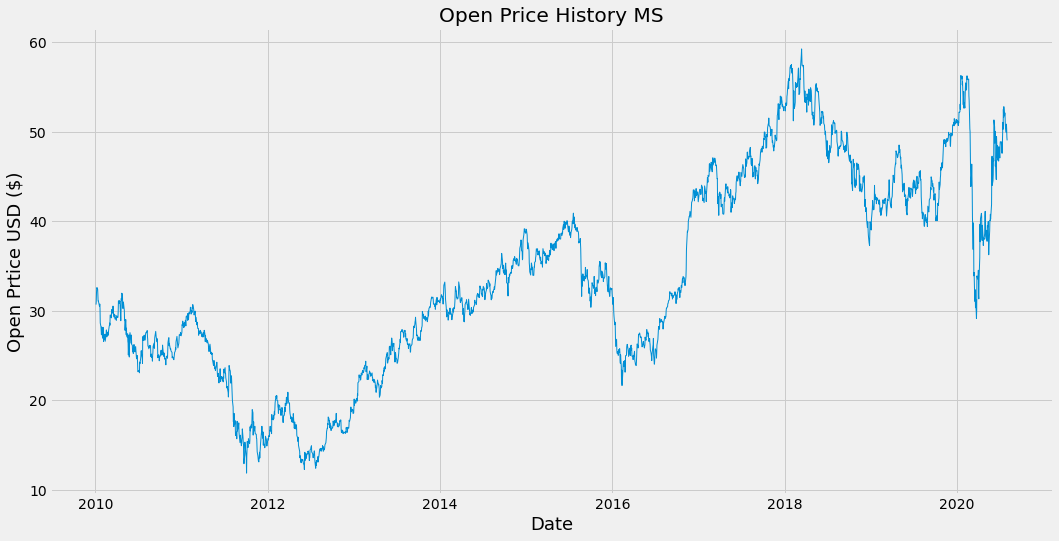

In [17]:
plt.figure(figsize=(16,8))
plt.title("Open Price History MS")
plt.plot(dfMS["MsOpen"],linewidth=1)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Open Prtice USD ($)", fontsize=18)
plt.show()  #useless

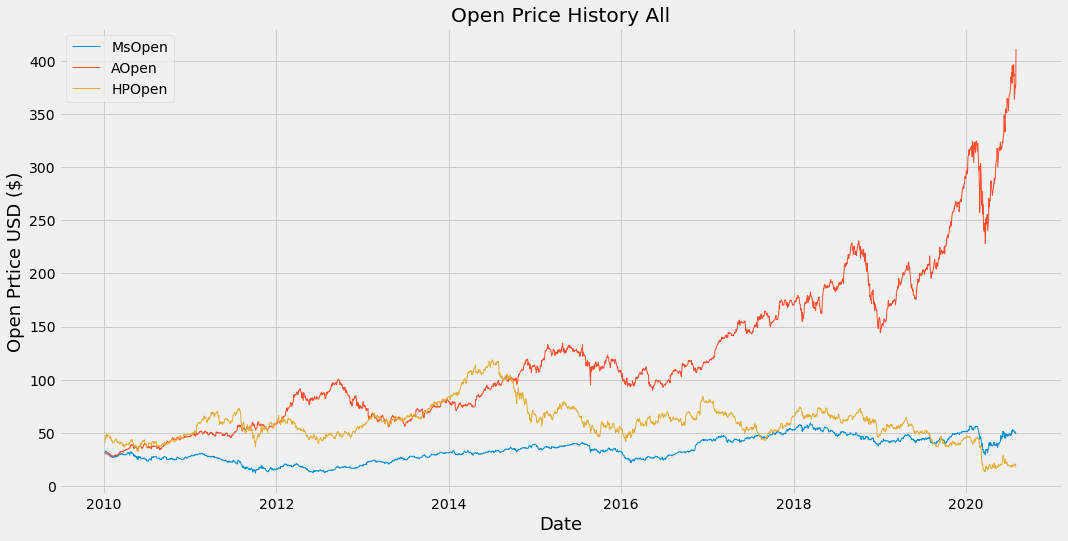

In [18]:
plt.figure(figsize=(16,8))#compare open prices
plt.title("Open Price History All")
plt.plot(result[["MsOpen","AOpen","HPOpen"]], linewidth=1)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Open Prtice USD ($)", fontsize=18)
plt.legend(["MsOpen","AOpen","HPOpen"], loc="upper left")

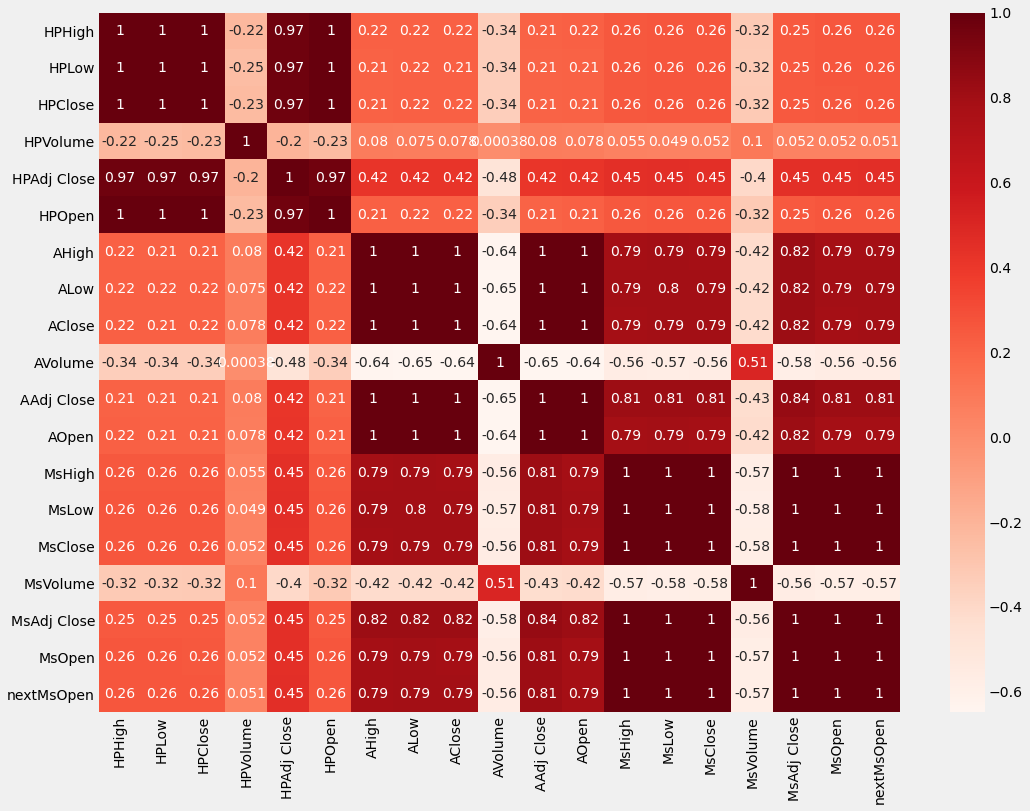

In [19]:
plt.figure(figsize=(8*2,6*2))
sns.heatmap(plotdata.corr(),annot=True,cmap='Reds')
 #obviously the values correlate (but to confirm)

Apple seems to have a relatively strong correlation with ms, while HP's corr isn't as strong but still not irrelevant

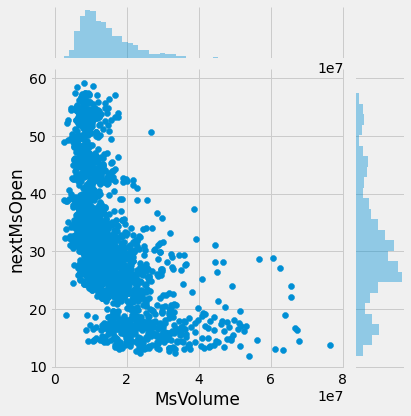

In [20]:
sns.jointplot(x="MsVolume", y="nextMsOpen", data=plotdata)

# Model

In [21]:
model=Sequential()
Neurons1=128*2
Neurons2=50*2
model.add(LSTM(Neurons1,return_sequences=True, input_shape=xTrain[0].shape))
model.add(LSTM(Neurons2,return_sequences=False))
model.add(Dense(25, activation="relu"))
model.add(Dense(1)) #=output
model.compile(optimizer="adam", loss="MSE", metrics=["MSE"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 256)           281600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               142800    
_________________________________________________________________
dense_1 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 426,951
Trainable params: 426,951
Non-trainable params: 0
_________________________________________________________________


# Training

In [22]:
# uses a saved model if it can, which speeds up/ skips the training phase
# tf.keras.backend.clear_session
try:
    # uncomment to train 
    model=keras.models.load_model("MS2.h5")
    print("Trainings data found.")
except:  
    print("training ...")
    model.fit(xTrain, yTrain, epochs=15,batch_size=1, verbose=1, workers=4) 
    
    # batch_size=higher =>worse resluts
    # if you want to speed up the Training, use less epochs(8 is probl. enough) or use the GPU
    model.save("MS2.h5")

Trainings data found.


# Predicitions

In [23]:
#get the real values
predictions = model.predict(xTest)

#scaled = scaler.fit(predictions)
#predictions = scaler.inverse_transform(predictions) # does not work because input != input we scaled (scaled 6 cols)
#predictions


#inserting new vals in xtest just to inversscale with the right vals to extract them
# this seems to be a very bad execution, but a better one does not come to mind right now

clone=dataSet[TrainDataLen:].copy()
for i in range(len(predictions)):
    clone[i][17]=predictions[i]
    
Pred = scaler.inverse_transform(list(clone))
pred=[]
for i in range(len(predictions)):
    pred.append([Pred[i][17]])
pred=np.array(pred)
pred[:5] #show how predictions look like

array([[49.67809666],
       [49.34168531],
       [48.66466008],
       [47.69274114],
       [47.4900211 ]])

In [24]:
model.evaluate(xTest, yTest)

532/532 [==============================] - 1s 2ms/sample - loss: 0.2367 - MSE: 0.2367


[0.23667991788763748, 0.23667993]

In [25]:
rsme= np.sqrt(np.mean(predictions-yTest)**2)#root mean squared error
print("RSME: ",rsme)

RSME:  0.4620553008638319


# Plot the data post Prediction

In [26]:
data=dfMS.filter(["MsOpen"]) # filter data to plot results
train=data[:TrainDataLen]
valid=data[TrainDataLen:]
valid["predictions"]=pred

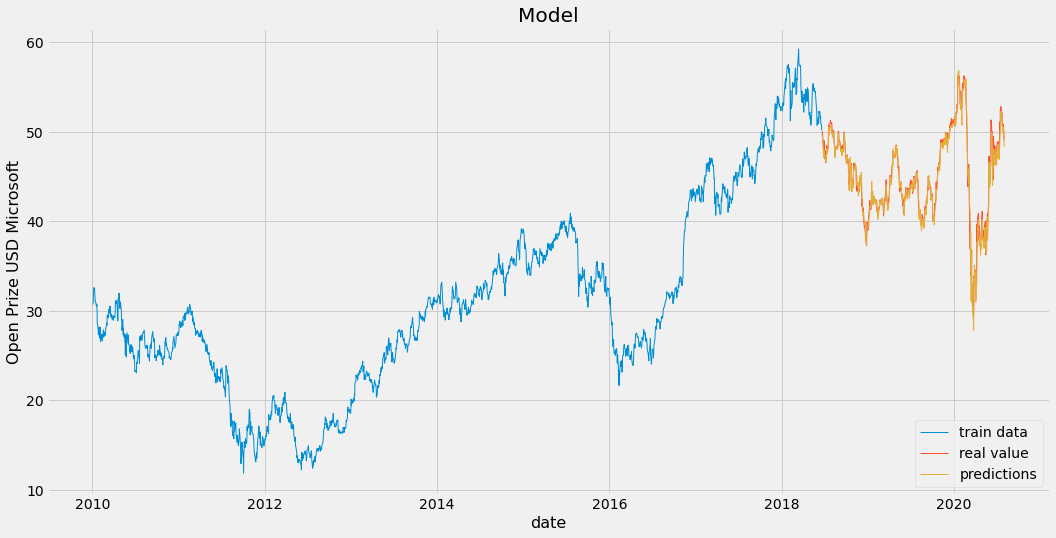

In [27]:
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("date", fontsize=16)
plt.ylabel("Open Prize USD Microsoft", fontsize=16)
plt.plot(train["MsOpen"],linewidth=1)
plt.plot(valid[["MsOpen", "predictions"]],linewidth=1)
plt.legend(["train data", "real value", "predictions"], loc="lower right")
plt.show()

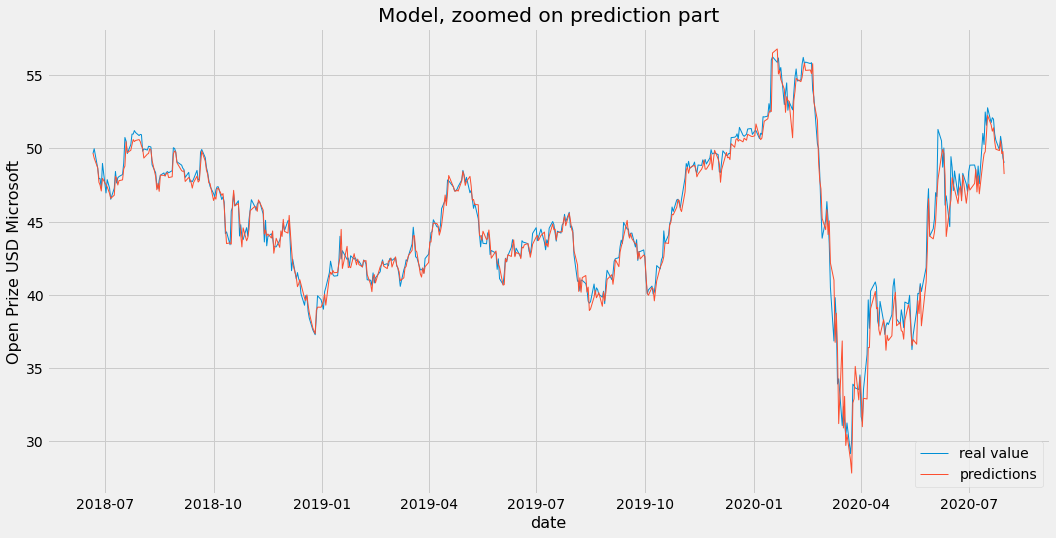

In [28]:
#zoomed in on new data
plt.figure(figsize=(16,8))
plt.ylabel("Open Prize USD Microsoft", fontsize=16)
plt.title("Model, zoomed on prediction part")
plt.xlabel("date", fontsize=16)
plt.plot(valid[["MsOpen", "predictions"]],linewidth=1)
plt.legend([ "real value", "predictions"], loc="lower right")
plt.show()

In [29]:
valid["dif(%)"]=((valid["MsOpen"]-valid["predictions"])/valid["MsOpen"])*100
valid["difABS(%)"]=abs(valid["dif(%)"])
valid

,MsOpen,predictions,dif(%),difABS(%)
Date,,,,
2018-06-21,49.660000,49.678097,-0.036441,0.036441
2018-06-22,49.980000,49.341685,1.277139,1.277139
2018-06-25,48.650002,48.664660,-0.030131,0.030131
2018-06-26,47.939999,47.692741,0.515764,0.515764
2018-06-27,47.939999,47.490021,0.938626,0.938626
...,...,...,...,...
2020-07-27,49.910000,49.855819,0.108558,0.108558
2020-07-28,50.830002,50.522730,0.604510,0.604510
2020-07-29,50.270000,49.643915,1.245445,1.245445


In [30]:
valid.describe()

,MsOpen,predictions,dif(%),difABS(%)
count,532.000000,532.000000,532.000000,532.000000
mean,45.062011,44.807484,0.548337,1.290263
std,4.813484,4.782613,1.995099,1.616708
min,29.150000,27.825243,-18.610183,0.000291
25%,41.980000,41.908247,-0.206440,0.378211
50%,44.650002,44.432334,0.514368,0.835895
75%,48.500000,48.159263,1.275514,1.543182
max,56.259998,56.796936,8.943152,18.610183


filtering pre Covid-19 lockdown data

In [31]:
preCovid=valid["2018-06-21":"2020-02-1"] #the date is a point before the big decline
preCovid.describe()

,MsOpen,predictions,dif(%),difABS(%)
count,406.000000,406.000000,406.000000,406.000000
mean,45.389877,45.224935,0.345320,0.868151
std,3.737247,3.654123,1.116478,0.781355
min,37.279999,37.347747,-4.762914,0.000291
25%,42.452500,42.321856,-0.256712,0.329732
50%,44.600000,44.415040,0.358108,0.686440
75%,48.340000,48.091941,0.965072,1.228693
max,56.259998,56.796936,6.287809,6.287809


# Feedback/Notes version 1 (see Github vers)
With the same Model parameters with which we predicted with only Ms Data, the Max error declined with the additional data, but the Mean increased a tiny bit (for comparison look at the other doc).<br>
with more neurons, the mean improves, but the max worsens. <br>
It is not sure, if I should use all data from the other stocks or if just 1 would do the trick(but I dont see it hurting the performance, just the time)<br><br>
# Problems
- ~~Something is wrong, every time i rerun the Model, the results get worse, not sure if batch_size, or Workers could be the reason.~~ The batch_size was the problem (for more info https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e)
- I don't know how to improve the "max" error